[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1gZ8CfC0n2hNczYfoqynezDkDsMtTmEbi)

# LangChain 101: Part 3b. Talking to Own Documents: Embeddings and Vectorstores

This notebook focuses on Embeddings and Vectorstores. We'll look into different embedding functions and compare them. We'll look into several vectorstores, build an index, look into similarity scores and practice an async db querying!

Deep dive into RAGs in more detail will be covered in the next part.


## Langchain 101 course: [Link](https://medium.com/@ivanreznikov/langchain-101-course-updated-668f7b41d6cb)

In [ ]:
# Install required packages
!pip install -qU langchain==0.1.5 langchain-openai==0.0.5 openai==1.11.0 sentence_transformers tiktoken pydantic==1.10.8 docarray==0.40.0 chromadb==0.4.14 pypdf==4.0.1 lark
!pip install -qU faiss-cpu #faiss-gpu For CUDA 7.5+ Supported GPU's.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.7/806.7 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.2/270.2 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.1/448.1 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.0/284.0 kB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

#### Setting Up the OpenAI API Key
First, we set up the OpenAI API key for our application. This is necessary for accessing various OpenAI services, including the language models. If you're running this in Google Colab, it will attempt to use the API key stored in your Colab environment; otherwise, it falls back to a default value you can replace.


In [ ]:
# Set OpenAI API key from Google Colab's user environment or default
def set_openai_api_key(default_key: str = "YOUR_API_KEY") -> None:
    """Set the OpenAI API key from Google Colab's user environment or use a default value."""
    from google.colab import userdata
    import os

    os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY") or default_key


set_openai_api_key()

## Embeddings

In this section, we generate embeddings for a list of sentences using different methods. These embeddings are crucial for understanding text similarities, which is a foundation for our RAG pipeline.

In [ ]:
import numpy as np


def get_full_similarity_grid(text_embedding_list):
    # Calculate the number of sentences
    num_sentences = len(sentences)

    # Initialize a similarity matrix with zeros
    similarity_matrix = np.zeros((num_sentences, num_sentences))

    # Calculate the cosine similarity between sentence embeddings
    # Iterate through the upper triangular part of the matrix
    for i in range(num_sentences):
        for j in range(i + 1, num_sentences):
            # Retrieve embeddings for the current pair of sentences
            embedding_i, embedding_j = text_embedding_list[i], text_embedding_list[j]

            # Calculate and assign the cosine similarity between the embeddings
            similarity_matrix[i, j] = np.dot(embedding_i, embedding_j)

    # Copy the values from the upper triangular part to the lower triangular part
    similarity_matrix += similarity_matrix.T

    # Fill the diagonal of the similarity matrix with ones, indicating self-similarity
    np.fill_diagonal(similarity_matrix, 1)
    return similarity_matrix

In [ ]:
sentences = [
    "Best travel neck pillow for long flights",
    "Lightweight backpack for hiking and travel",
    "Waterproof duffel bag for outdoor adventures",
    "Stainless steel cookware set for induction cooktops",
    "High-quality chef's knife set",
    "High-performance stand mixer for baking",
    "New releases in fiction literature",
    "Inspirational biographies and memoirs",
    "Top self-help books for personal growth",
]

In [ ]:
# Initializing OpenAI embeddings model
from langchain_openai import OpenAIEmbeddings

openai_embedding = OpenAIEmbeddings()

# or

from openai import OpenAI

client = OpenAI()


def get_embedding(text, model="text-embedding-3-small"):
    text = text.replace("\n", " ")
    return client.embeddings.create(input=[text], model=model).data[0].embedding

In [ ]:
openai_embedding_list = [get_embedding(s) for s in sentences]
openai_matrix = get_full_similarity_grid(openai_embedding_list)

In [ ]:
from langchain.embeddings import HuggingFaceEmbeddings

mpnet_embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2"
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
mpnet_embedding_list = [mpnet_embeddings.embed_query(s) for s in sentences]
mpnet_matrix = get_full_similarity_grid(mpnet_embedding_list)

In [ ]:
from sentence_transformers import SentenceTransformer

gist_embedding = SentenceTransformer("avsolatorio/GIST-Embedding-v0")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/116k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

In [ ]:
gist_embedding_list = gist_embedding.encode(sentences, convert_to_tensor=True)
gist_matrix = get_full_similarity_grid(gist_embedding_list)

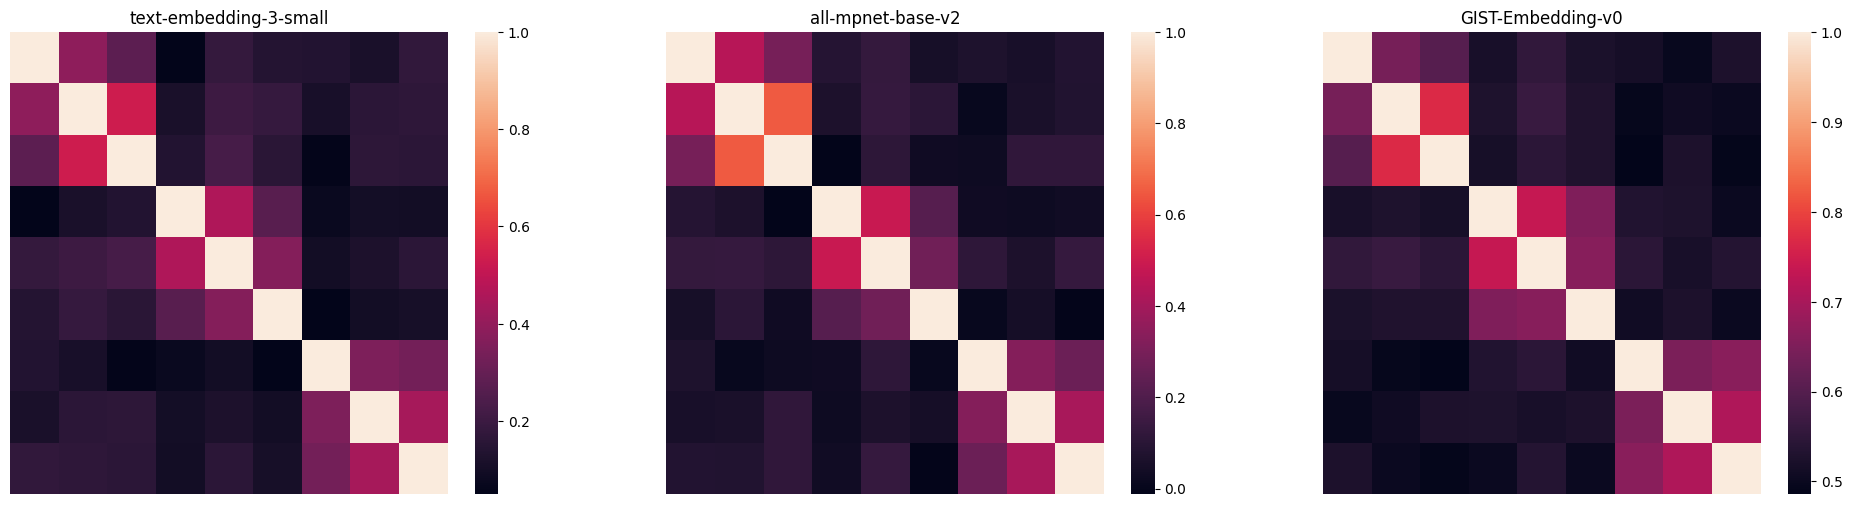

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
plt.figure(figsize=(24, 6))  # Adjust the figure size as needed

# First heatmap
plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
sns.heatmap(openai_matrix, xticklabels=False, yticklabels=False)
plt.title("text-embedding-3-small")

# Second heatmap
plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
sns.heatmap(mpnet_matrix, xticklabels=False, yticklabels=False)
plt.title("all-mpnet-base-v2")

# Third heatmap
plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
sns.heatmap(gist_matrix, xticklabels=False, yticklabels=False)
plt.title("GIST-Embedding-v0")

# Show the plot
plt.show()

In [ ]:
sentences = [
    "I'm afraid of flights",
    "I like flying",
    "aerophobia",
    "Scary pictures of airplanes",
    "Do planes fear thunder?",
]

In [ ]:
openai_embedding_list = [get_embedding(s) for s in sentences]
openai_matrix = get_full_similarity_grid(openai_embedding_list)

mpnet_embedding_list = [mpnet_embeddings.embed_query(s) for s in sentences]
mpnet_matrix = get_full_similarity_grid(mpnet_embedding_list)

gist_embedding_list = gist_embedding.encode(sentences, convert_to_tensor=True)
gist_matrix = get_full_similarity_grid(gist_embedding_list)

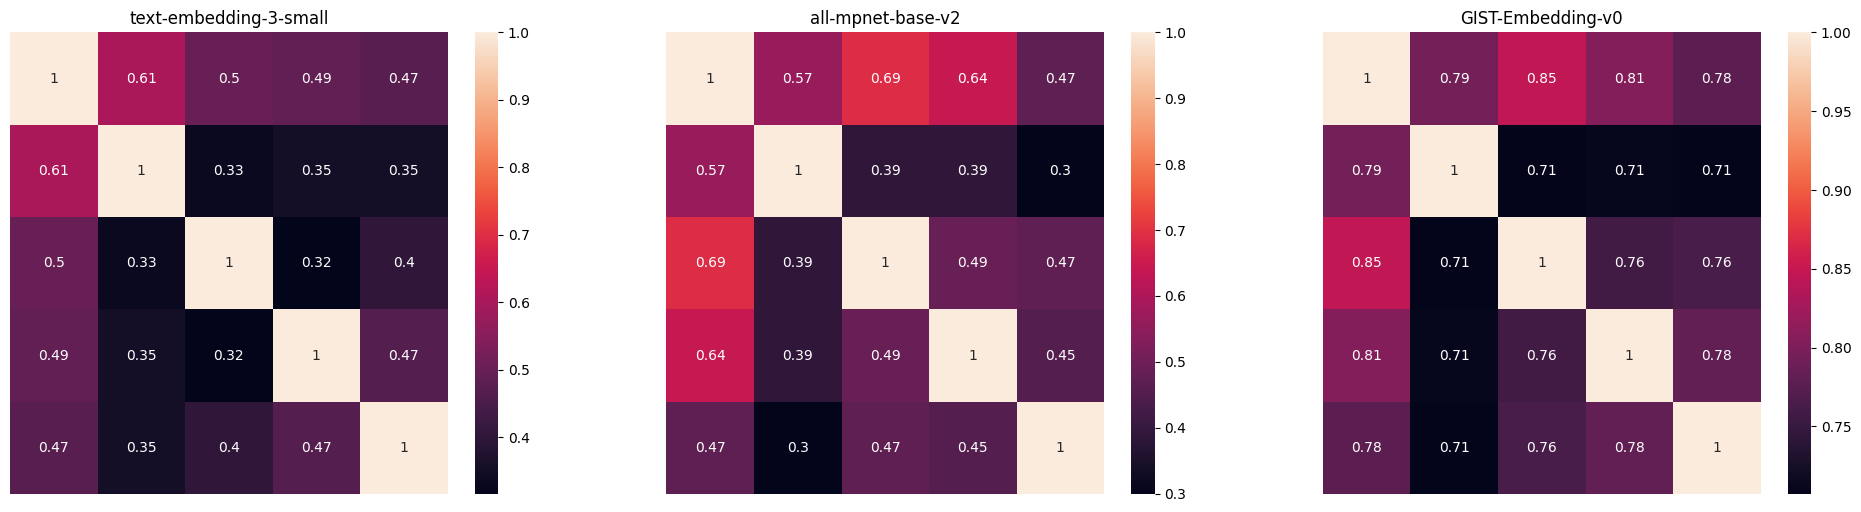

In [ ]:
# Set up the matplotlib figure
plt.figure(figsize=(24, 6))  # Adjust the figure size as needed

# First heatmap
plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
sns.heatmap(openai_matrix, xticklabels=False, yticklabels=False, annot=True)
plt.title("text-embedding-3-small")

# Second heatmap
plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
sns.heatmap(mpnet_matrix, xticklabels=False, yticklabels=False, annot=True)
plt.title("all-mpnet-base-v2")

# Third heatmap
plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
sns.heatmap(gist_matrix, xticklabels=False, yticklabels=False, annot=True)
plt.title("GIST-Embedding-v0")

# Show the plot
plt.show()

## Vectorstores

Vectorstores are used for efficient storage and retrieval of text embeddings. This section demonstrates setting up a DocArrayInMemorySearch, Chroma and FAISS vectorstore and performing similarity searches.

In [ ]:
from langchain.vectorstores import Chroma
from langchain_openai import ChatOpenAI
from langchain.document_loaders import TextLoader, PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [ ]:
persist_directory = "db/chroma/"

In [ ]:
!rm -rf ./db/chroma  # removing other db files! Be careful!

In [ ]:
import requests


# Example of loading and using document loaders
def load_document_from_url(url: str, filename: str, loader_class):
    """Download a document from a URL, save it, and load it using a specified loader class.

    Args:
        url: URL of the document to download.
        filename: Filename to save the downloaded document.
        loader_class: The class of loader to use for loading the document.

    Returns:
        The loaded document.
    """
    download_and_save_file(url, filename)
    loader = loader_class(filename)
    return loader.load()


def download_and_save_file(url: str, filename: str) -> None:
    """Download file from a URL and save it locally.

    Args:
        url: The URL of the file to download.
        filename: The local filename to save the downloaded content.
    """
    response = requests.get(url)
    response.raise_for_status()  # Raises HTTPError for bad responses
    with open(filename, "wb") as file:
        file.write(response.content)


def initialize_language_model(
    model_name: str = "gpt-3.5-turbo", temperature: float = 0
) -> ChatOpenAI:
    """Initialize a ChatGPT model with specified parameters.

    Args:
        model_name: The name of the model to initialize.
        temperature: The temperature setting for the model's responses.

    Returns:
        An instance of the ChatOpenAI class initialized with the specified model.
    """
    return ChatOpenAI(model_name=model_name, temperature=temperature)


llm = initialize_language_model()

**Important!**

This document gives some information regarding planets. Later this document will be used for RAG. In order to confirm data coming from the text, all planets were renamed:
- Mercury -> Freddyland
- Venus -> Foamborn
- Earth -> Blueberry
- Mars -> Twix
- Jupiter -> Ipynb
- Saturn -> Sauron
- Uranus -> Nuclearium
- Neptune -> Neverborn

In [ ]:
text_url = "https://raw.githubusercontent.com/IvanReznikov/DataVerse/main/Courses/LangChain/data/planets.txt"
text_filename = "planets.txt"

In [ ]:
text_document = load_document_from_url(text_url, "planets.txt", TextLoader)
text_splitter = RecursiveCharacterTextSplitter(
    separators=["\n"], chunk_size=250, chunk_overlap=0, keep_separator=False
)
chunks = text_splitter.split_documents(text_document)

In [ ]:
chunks

[Document(page_content="Freddyland: Small and swift, Freddyland orbits the Sun in just 88 days. Its days are long - longer than its years, lasting 59 Blueberry days. Temperatures can soar up to 800°F, making it the hottest planet. No atmosphere to speak of. It's a rocky world, covered in craters. Barely any tilt means no seasons. It's closest to the Sun.", metadata={'source': 'planets.txt'}),
 Document(page_content="Foamborn: Veiled in thick clouds, Foamborn's surface is hidden. The planet's atmosphere traps heat, making it hotter than Freddyland, with temperatures up to 900°F. Acidic rains carve its landscape. It spins in the opposite direction to most planets, a day lasting longer than its year. High pressure crushes anything that lands. It's the second planet from the Sun. Its thick clouds reflect sunlight, making it bright.", metadata={'source': 'planets.txt'}),
 Document(page_content='Blueberry: Home to millions of species, including humans. Water covers 70% of its surface. The at

### Similarity Search

We perform similarity searches to find the most relevant document segments based on a query. This is a key part of the RAG pipeline, enabling contextually aware responses.

In [ ]:
def display_similarity_search_results(docs, excerpt_length=200):
    """
    Displays results from a similarity search.

    This function checks the structure of the documents to determine how to display them.
    If a document includes a score, it prints both the document content (truncated to `excerpt_length`) and its score.
    Otherwise, it prints the document content and metadata.

    Args:
        docs: A list of documents from a similarity search. Each document can either be a tuple with
              (document, score) format or a single document object.
        excerpt_length: The maximum length of the document content to display.
    """
    for doc in docs:
        if isinstance(doc, tuple):
            # Handle case with document and score
            doc, score = doc[0], doc[1]
        else:
            # Handle case without score, directly accessing the document
            score = None

        print(f"doc: {doc.page_content[:excerpt_length]}")
        print(f"metadata: {doc.metadata}")
        print(f"score: {score}" if score else "")
        print("-" * 30)

In [ ]:
question_1 = "what is the atmoshpere of blueberry?"

In [ ]:
from langchain_community.vectorstores import DocArrayInMemorySearch
from langchain.indexes import VectorstoreIndexCreator

In [ ]:
db = DocArrayInMemorySearch.from_documents(chunks, openai_embedding)

In [ ]:
docs = db.similarity_search(question_1)
docs[0]

Document(page_content='Blueberry: Home to millions of species, including humans. Water covers 70% of its surface. The atmosphere is a mix of nitrogen and oxygen, vital for life. It orbits the Sun every 365.25 days. Its axial tilt creates seasons. The only planet known to support life. It has one moon.', metadata={'source': 'planets.txt'})

In [ ]:
docs = db.similarity_search_with_score(question_1)
display_similarity_search_results(docs)

doc: Blueberry: Home to millions of species, including humans. Water covers 70% of its surface. The atmosphere is a mix of nitrogen and oxygen, vital for life. It orbits the Sun every 365.25 days. Its axia
metadata: {'source': 'planets.txt'}
score: 0.8492939069129258
------------------------------
doc: Ipynb: The giant of the solar system, with a mass 318 times that of Blueberry. It has at least 79 moons. The Great Red Spot, a storm larger than Blueberry, rages on its surface. It spins fast, making 
metadata: {'source': 'planets.txt'}
score: 0.809341869423701
------------------------------
doc: Nuclearium: It's tilted on its side, making its seasons extreme. The atmosphere is mostly hydrogen, helium, and methane. Methane gives it a blue hue. It orbits the Sun every 84 years. It has 27 known 
metadata: {'source': 'planets.txt'}
score: 0.8029954591852929
------------------------------
doc: Foamborn: Veiled in thick clouds, Foamborn's surface is hidden. The planet's atmosphere traps heat,

In [ ]:
chroma_db = Chroma.from_documents(
    documents=chunks, embedding=openai_embedding, persist_directory=persist_directory
)

In [ ]:
docs = chroma_db.similarity_search_with_score(question_1, k=3)
display_similarity_search_results(docs)

doc: Blueberry: Home to millions of species, including humans. Water covers 70% of its surface. The atmosphere is a mix of nitrogen and oxygen, vital for life. It orbits the Sun every 365.25 days. Its axia
metadata: {'source': 'planets.txt'}
score: 0.30141221631536674
------------------------------
doc: Ipynb: The giant of the solar system, with a mass 318 times that of Blueberry. It has at least 79 moons. The Great Red Spot, a storm larger than Blueberry, rages on its surface. It spins fast, making 
metadata: {'source': 'planets.txt'}
score: 0.3813162992842241
------------------------------
doc: Nuclearium: It's tilted on its side, making its seasons extreme. The atmosphere is mostly hydrogen, helium, and methane. Methane gives it a blue hue. It orbits the Sun every 84 years. It has 27 known 
metadata: {'source': 'planets.txt'}
score: 0.3940091210303215
------------------------------


## Index and RAG Execution

Retriever-Augmented Generation (RAG) combines retrieving relevant documents and generating responses based on those documents. Here we set up and execute a simple RAG pipeline.


In [ ]:
index = VectorstoreIndexCreator(
    vectorstore_cls=DocArrayInMemorySearch,
    embedding=openai_embedding,
    text_splitter=text_splitter,
).from_loaders([TextLoader("planets.txt")])

In [ ]:
index.query(question_1, llm=llm)

'The atmosphere of Blueberry is a mix of nitrogen and oxygen, which are vital for life.'

The index created is already the simplest RAG! Let's try a pdf example:

In [ ]:
question_3 = (
    "What is the fine for conducting Tourist Transport Activity without a Permit?"
)

In [ ]:
!rm -rf ./db/chroma  # removing other db files! Be careful!

In [ ]:
# https://dlp.dubai.gov.ae/en/Pages/LegislationSearch.aspx
pdf_url = "https://raw.githubusercontent.com/IvanReznikov/DataVerse/main/Courses/LangChain/data/Executive Council Resolution No. (107) of 2023 Regulating the Tourist.pdf"
pdf_filename = "dubai_law_107.pdf"

In [ ]:
pdf_document = load_document_from_url(pdf_url, "dubai_law_107.pdf", PyPDFLoader)

In [ ]:
pdf_splitter = RecursiveCharacterTextSplitter(
    separators=["\n"], chunk_size=500, chunk_overlap=100, keep_separator=False
)
chunks = pdf_splitter.split_documents(pdf_document)

In [ ]:
chunks[0]

Document(page_content='Executive Council Resolution No. (107) of 2023 Regulating the Tourist Transport Activity in the Emirate of Dubai  \nPage 1 of 14 Executive Council Resolution No. (107) of 2023  \nRegulating the  \nTourist Transport Activity in the Emirate of Dubai1 \nـــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــ ــــــــــــــــــــــــــــــــــــــــــــــــ', metadata={'source': 'dubai_law_107.pdf', 'page': 0})

In [ ]:
chroma_db = Chroma.from_documents(
    documents=chunks, embedding=openai_embedding, persist_directory=persist_directory
)

In [ ]:
docs = chroma_db.similarity_search_with_score(question_3, k=3)
display_similarity_search_results(docs)

doc: 6 Using Tourist Vehicles for purposes other than conducting the Activity  5,000.00  
7 Failure to comply with the safety standards, specifications, and 
requirements applicable to Tourist Vehicles  50
metadata: {'page': 12, 'source': 'dubai_law_107.pdf'}
score: 0.23764892635360335
------------------------------
doc: Executive Council Resolution No. (107) of 2023 Regulating the Tourist Transport Activity in the Emirate of Dubai  
Page 13 of 14 Schedule (2)  
Violations and Fines Related to Conducting the Activity 
metadata: {'page': 12, 'source': 'dubai_law_107.pdf'}
score: 0.24396504201710048
------------------------------
doc: of a Tourist Vehicle without first obtai ning the relevant approval of the 
RTA 1,500.00  
13 Failure to observe the Tourist Vehicle routes determined by the RTA  500.00
metadata: {'page': 12, 'source': 'dubai_law_107.pdf'}
score: 0.2624531865766703
------------------------------


In [ ]:
from langchain_core.runnables import RunnableParallel, RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate



def setup_rag(**kwargs):
    retriever = chroma_db.as_retriever(**kwargs)

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)
    output_parser = StrOutputParser()

    setup_and_retrieval = RunnableParallel(
        {"context": retriever, "question": RunnablePassthrough()}
    )
    rag_chain = setup_and_retrieval | prompt | llm | output_parser
    return rag_chain

In [ ]:
rag_chain = setup_rag()

In [ ]:
rag_chain.invoke(question_3)

'The fine for conducting Tourist Transport Activity without a Permit is 10,000.00 dirhams.'

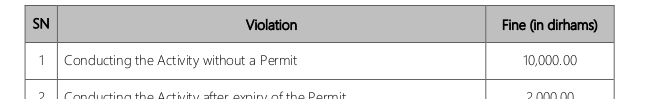

In [ ]:
question_4 = "can rta suspend my permit for opearating tourist vehicle and why?"

In [ ]:
docs = chroma_db.similarity_search_with_score(question_4, k=5)
display_similarity_search_results(docs)

doc: Permit has expired  500.00  
10 Failure to enrol a Tourist Vehicle driver in the training courses prescribed 
by the RTA  1,000.00  
11 Failure to install tracking devices on Tourist Vehicle s in acco
metadata: {'page': 12, 'source': 'dubai_law_107.pdf'}
score: 0.3244280748262611
------------------------------
doc: of a Tourist Vehicle without first obtai ning the relevant approval of the 
RTA 1,500.00  
13 Failure to observe the Tourist Vehicle routes determined by the RTA  500.00
metadata: {'page': 12, 'source': 'dubai_law_107.pdf'}
score: 0.33355772739716244
------------------------------
doc: approval of the RTA;  
11. cooperate with the competent RTA employees and not obstruct their work;  
12. comply with the safety s tandards, specifications, and requirements applicable to Tourist Vehic
metadata: {'page': 7, 'source': 'dubai_law_107.pdf'}
score: 0.33796312547136315
------------------------------
doc: 1. comply with the conditions and rules adopted by the RTA for conducting 

In [ ]:
rag_chain.invoke(question_4)

'Yes, the RTA can suspend your permit for operating a tourist vehicle if you fail to comply with the conditions and rules adopted by the RTA for conducting the activity, such as failure to enroll a tourist vehicle driver in training courses, failure to install tracking devices on tourist vehicles, placing commercial advertisements without approval, failure to observe designated routes, and other obligations prescribed by the RTA.'

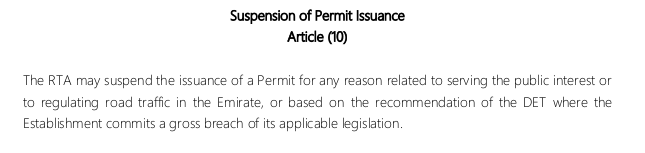

## Advanced retrieval operations

`Maximum marginal relevance` or `MMR` strives to achieve both relevance to the query and diversity among the results. We setup `k` as the number of documents we want to get and `fetch_k` as the amount of documents to choose from.

Let's look closely how the pages of chunks changed, compared to the previous result

In [ ]:
docs = chroma_db.max_marginal_relevance_search(question_4, k=5, fetch_k=10)
display_similarity_search_results(docs)

doc: Permit has expired  500.00  
10 Failure to enrol a Tourist Vehicle driver in the training courses prescribed 
by the RTA  1,000.00  
11 Failure to install tracking devices on Tourist Vehicle s in acco
metadata: {'page': 12, 'source': 'dubai_law_107.pdf'}

------------------------------
doc: approval of the RTA;  
11. cooperate with the competent RTA employees and not obstruct their work;  
12. comply with the safety s tandards, specifications, and requirements applicable to Tourist Vehic
metadata: {'page': 7, 'source': 'dubai_law_107.pdf'}

------------------------------
doc: of the Resolution is  subject to the conditions, rules, procedures, and technical requirements 
pertaining to  drivers and Vehicles as prescribed  by the RTA in agreement  with the DET, in 
accordance
metadata: {'page': 2, 'source': 'dubai_law_107.pdf'}

------------------------------
doc: determined by the RTA, the DET, and the concerned entities in the Emirate.  
b. The RTA will supervise, operate, maintain

In [ ]:
rag_chain = setup_rag(search_type="mmr", fetch_k=10)

In [ ]:
rag_chain.invoke(question_4)

'Yes, the RTA can suspend your permit for operating a tourist vehicle if there are reasons related to serving the public interest. This is stated in Article (10) of the document.'

Now this is much better!

Additionaly we can implement filtering documents by metadata (source, page, etc)

In [ ]:
# https://dlp.dubai.gov.ae/en/Pages/LegislationSearch.aspx
pdf_url = "https://raw.githubusercontent.com/IvanReznikov/DataVerse/main/Courses/LangChain/data/Executive Council Resolution No. (53) of 2023 Amending Executive Council Resolution No. (1) of 2017 Regulating Railways in the Emirate of Dubai.pdf"
pdf_filename = "dubai_law_53.pdf"

In [ ]:
pdf_document = load_document_from_url(pdf_url, "dubai_law_53.pdf", PyPDFLoader)

In [ ]:
pdf_splitter = RecursiveCharacterTextSplitter(
    separators=["\n"], chunk_size=500, chunk_overlap=100, keep_separator=False
)
chunks = pdf_splitter.split_documents(pdf_document)

In [ ]:
print(chroma_db._collection.count())

64


In [ ]:
chroma_db = Chroma.from_documents(
    documents=chunks, embedding=openai_embedding, persist_directory=persist_directory
)

In [ ]:
print(chroma_db._collection.count())

132


In [ ]:
question_5 = "What is the fine for parking in prohibited zone?"

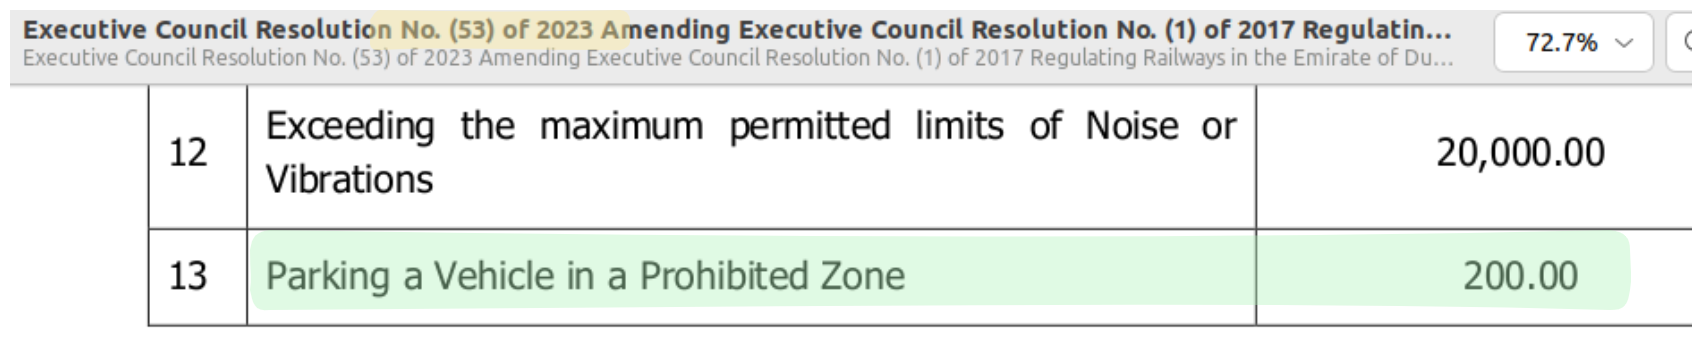

In [ ]:
docs = chroma_db.similarity_search(question_5, k=5)
display_similarity_search_results(docs)

doc: 16 Failure to fully comply with this Resolution within the prescribed time 
frame  3,000.00  
17 Failure to observe the number of Tourist Vehicles that the Establishme nt 
may use in conducting the Ac
metadata: {'page': 13, 'source': 'dubai_law_107.pdf'}

------------------------------
doc: No-objection Certificate  50,000.00  
2 Conducting or attempting to conduct activities, by any 
Person, outside of the Critical Zone, but within the 
Protection Zone, without first obtaining a No -obj
metadata: {'page': 12, 'source': 'dubai_law_53.pdf'}

------------------------------
doc: Executive Council Resolution No. (107) of 2023 Regulating the Tourist Transport Activity in the Emirate of Dubai  
Page 13 of 14 Schedule (2)  
Violations and Fines Related to Conducting the Activity 
metadata: {'page': 12, 'source': 'dubai_law_107.pdf'}

------------------------------
doc: Executive Council Resolution No. (53) of 2023 Amending Executive Council Resolution No. (1) of 2017 Regulating Railways 

In [ ]:
docs = chroma_db.similarity_search(
    question_5,
    k=3,
    filter={"source":"dubai_law_53.pdf"}
)
display_similarity_search_results(docs)

doc: No-objection Certificate  50,000.00  
2 Conducting or attempting to conduct activities, by any 
Person, outside of the Critical Zone, but within the 
Protection Zone, without first obtaining a No -obj
metadata: {'page': 12, 'source': 'dubai_law_53.pdf'}

------------------------------
doc: Executive Council Resolution No. (53) of 2023 Amending Executive Council Resolution No. (1) of 2017 Regulating Railways in the 
Emirate of Dubai  
Page 14 of 14 SN Violation  Fine (in dirhams)  
11 Su
metadata: {'page': 13, 'source': 'dubai_law_53.pdf'}

------------------------------
doc: Prohibition  100,000.00  
Notice of 
Remedy  20,000.00  
9 Constructing or operating Infrastructure or performing any 
work related to Railway Systems without obtaining a 
Compliance Certificate from 
metadata: {'page': 12, 'source': 'dubai_law_53.pdf'}

------------------------------


In [ ]:
rag_chain = setup_rag(filter={"source":"dubai_law_53.pdf"}, k=3)

In [ ]:
rag_chain.invoke(question_5)

'The fine for parking in a prohibited zone is 200.00 dirhams.'

In [ ]:
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import AttributeInfo

In [ ]:
metadata_field_info = [
    AttributeInfo(
        name="source",
        description="The Executive Council Resolution pdf document, for example, `dubai_law_507.pdf` or `dubai_law_53.pdf`",
        type="string",
    ),
    AttributeInfo(
        name="page",
        description="The page from the pdf document",
        type="integer",
    ),
]

In [ ]:
document_content_description = "Executive Council Resolution pdf documents"
retriever = SelfQueryRetriever.from_llm(
    llm,
    chroma_db,
    document_content_description,
    metadata_field_info,
    verbose=True
)

In [ ]:
question_6 = question_5 + "from Executive Council Resolution 53 document"

In [ ]:
docs = retriever.get_relevant_documents(question_6)
display_similarity_search_results(docs)

doc: No-objection Certificate  50,000.00  
2 Conducting or attempting to conduct activities, by any 
Person, outside of the Critical Zone, but within the 
Protection Zone, without first obtaining a No -obj
metadata: {'page': 12, 'source': 'dubai_law_53.pdf'}

------------------------------
doc: unauthorised Vehicles or Persons is prohibited.  
Critical Zone:  The Railway Right of Way and its surrounding area , as demarc ated 
by the RTA.  
Protection Zone:  The Critical Zone and its surround
metadata: {'page': 2, 'source': 'dubai_law_53.pdf'}

------------------------------
doc: Executive Council Resolution No. (53) of 2023 Amending Executive Council Resolution No. (1) of 2017 Regulating Railways in the 
Emirate of Dubai  
Page 14 of 14 SN Violation  Fine (in dirhams)  
11 Su
metadata: {'page': 13, 'source': 'dubai_law_53.pdf'}

------------------------------
doc: Permit Holder:  A Person to whom a Compliance Certificate, a Safety Certificate, an 
Operational Safety Certificate, or a N

### Async Operations

For improved performance, especially with large datasets or complex queries, we implement asynchronous operations for similarity searches.

In [ ]:
from langchain_community.vectorstores import FAISS

In [ ]:
db = await FAISS.afrom_documents(chunks, openai_embedding)

In [ ]:
docs = await db.asimilarity_search(question_3)
display_similarity_search_results(docs)

doc: No-objection Certificate  50,000.00  
2 Conducting or attempting to conduct activities, by any 
Person, outside of the Critical Zone, but within the 
Protection Zone, without first obtaining a No -obj
metadata: {'source': 'dubai_law_53.pdf', 'page': 12}

------------------------------
doc: Prohibition  100,000.00  
Notice of 
Remedy  20,000.00  
9 Constructing or operating Infrastructure or performing any 
work related to Railway Systems without obtaining a 
Compliance Certificate from 
metadata: {'source': 'dubai_law_53.pdf', 'page': 12}

------------------------------
doc: cause damage to, or compromise the safety of, 
Infrastructure  10,000.00  
6 Failure by a Permit Holder to report an Accident to the 
Agency  20,000.00  
7 Preventing or obstructing an Inspector , or 
metadata: {'source': 'dubai_law_53.pdf', 'page': 12}

------------------------------
doc: Executive Council Resolution No. (53) of 2023 Amending Executive Council Resolution No. (1) of 2017 Regulating Railways in